In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fmin_slsqp

## Dry Reforming of Methane (DRM)

Equilibrium Thermodynamics of the Dry Reforming Reaction Depicting the Conversion of Reactants CH$_4$ and CO$_2$ to CO, H$_2$, H$_2$O, and C as a Function of Temperature.

### i) Equilibrium Composition - without solid carbon C(s)

### 1st method with CANTERA

In [2]:
# create empty list to store data
ch4_eq_combined = []
co2_eq_combined = []
h2o_eq_combined = []
h2_eq_combined = []
co_eq_combined = []
h2_co_ratio_combined = []
Xch4_eq_combined = []
Xco2_eq_combined = []
Xh2_eq_combined = []
Xco_eq_combined = []

Temp_range = np.linspace(300+273.15, 1000+273.15, 10)
ch4, co2, h2o, h2, co = np.arange(5)

for Temp in Temp_range:

    gas = ct.Solution('gri30.yaml')
    molar_ratio = {'CH4': 1/2, 'CO2':1/2, 'H2O':0.0, 'H2':0.0, 'CO':0.0}
    pressure = 101325
    gas.TPX = Temp, pressure, molar_ratio
    
    # transport properties
    feed = gas['CH4', 'CO2', 'H2O', 'H2', 'CO']
             
    ρ_mix = (feed.density, 'kg/m^3')
    H_mix_mass = (feed.enthalpy_mass, 'J/kg')
    H_mix_mole = (feed.enthalpy_mole, 'J/kmol')
    cp_mix_mass = (feed.cp_mass, 'J/Kg/K')
    cp_mix_mole = (feed.cp_mole, 'J/kmol/K')
    Mr_mix = (feed.mean_molecular_weight, 'kg/kmol')
    n_species = feed.n_selected_species
    Di_mole = (feed.mix_diff_coeffs_mole, 'm^2/s')
    μ = (feed.viscosity, 'Pa*s')
    
    # partial molar properties
    Yi_feed = feed.Y # mass fractions
    Xi_feed = feed.X # molar fractions
    Mri = (feed.molecular_weights, 'kg/kmol')
    cpi = (feed.partial_molar_cp/1000, 'J/mol/K')
    Hi = (feed.partial_molar_enthalpies/1000, 'J/mol')
    Ci = (feed.concentrations, 'kmol/m^3')
    
    # equilibrate temperature, pressure
    feed.equilibrate('TP')
    
    ch4_eq = feed.X[0]*1
    ch4_eq_combined.append(ch4_eq)

    co2_eq = feed.X[1]*1
    co2_eq_combined.append(co2_eq)    
    
    h2o_eq = feed.X[2]
    h2o_eq_combined.append(h2o_eq)        
    
    h2_eq = feed.X[3]
    h2_eq_combined.append(h2_eq)    
    
    co_eq = feed.X[4]
    co_eq_combined.append(co_eq)       

    
    h2_co_ratio = h2_eq/co_eq   
    h2_co_ratio_combined.append(h2_co_ratio)
    
    # conversions
    Xch4_eq = ((molar_ratio['CH4'] - ch4_eq)/molar_ratio['CH4'])*100
    Xch4_eq_combined.append(Xch4_eq)
    
    Xco2_eq = ((molar_ratio['CO2'] - co2_eq)/molar_ratio['CO2'])*100
    Xco2_eq_combined.append(Xco2_eq)  
    
    Xh2_eq = ((h2_eq)/(2*molar_ratio['CH4']))*100
    Xh2_eq_combined.append(Xh2_eq)      
    
    Xco_eq = ((co_eq)/(molar_ratio['CO2'] + molar_ratio['CH4']))*100
    Xco_eq_combined.append(Xco_eq)

### 2nd method with GIBBS MINIMIZATION - (NIST DATA)

In [3]:
species = ['CH$_4$', 'CO$_2$', 'H$_2$O', 'H$_2$', 'CO']

def Gibbs_formation_gas(T):
   
    # Heats of formation at 298.15 K in kJ/mol
    Hf298 = [
        -74.85,   # CH4
        -393.51,  # CO2
        -241.826, # H2O
           0.0,   # H2
        -110.53   # CO
               ]   

    # Shomate parameters for each species
    #           A          B           C          D          E            F          G       H
    WB = [
          [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],       # CH4
          [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],       # CO2
          [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],       # H2O
          [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,    0.0],          # H2        
          [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271]        # CO
    ]     

    WB = np.array(WB)

    # Shomate equations
    t = T/1000
    T_H = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0])
    T_S = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0])

    H = np.dot(WB, T_H)        # (H - H_298.15) kJ/mol
    S = np.dot(WB, T_S/1000.0) # absolute entropy kJ/mol/K

    Gjo = Hf298 + H - T*S
    
    return Gjo # is the standard free energy in kJ/mol

Gibbs_formation_gas(273.15)

array([-125.76245129, -451.94862239, -293.4420287 ,  -35.72617378,
       -164.54985832])

### Gibbs energy of a mixture

$G^T={\sum_{j=1}^Ν n_j\bar{G_j}}={\sum_{n_j} n_j\mu_j}={\sum{n_jG_j^o}+RT{\sum{n_j}ln\frac{\hat{f_j}}{\hat{f_j^o}}}}$

where

$\mu_j=G^o_j+RTlna_j$

As high temperatures and low pressures are involved, the gas mixture could be treated as ideal with fugacities replaced with partial pressures.

$a_j=y_j\frac{P}{P_o}=\frac{n_j}{\sum n_j}\frac{P}{P_o}$


$G^T={\sum_{j=1}^n n_j}(G_j^o+RTln\frac{n_j}{\sum n_j}\frac{P}{P_o})$

where

$G^T$ is the total Gibbs free energy in kJ/mol\
$\bar{G_j}$ is the is the partial molar Gibbs free energy of the species $j$ in kJ/mol\
$G^o_j$ is the standard free energy in kJ/mol\
$\hat{f_j}$ is the fugasivity of the component j\
$\mu_j$ is the chemical potential\
$R$ is the universal gas constant in kJ/mol/K\
$T$ is the system temperature in K\
$P$ is the system pressure in atm\
$n_j$ is the moles of species j in mol\
$y_j$ is the mole fraction in gas phase

In gas-phase system, $G^o_j=\Delta G^o_{fj}$ is assumed and $P_o$ is the pressure of the standard state (e.g., 1 atm). The units of $P_o$ must be the same as the system's pressure ($P$) in order to obtain a dimensionless number within the logarithm.

Together with the limiting equations for conversion of existing elements

${\sum_{j} n_j\alpha_{jk}}=A_k$

where

$a_{jk}$ is the number of atoms of the kth element in each molecular species j\
$A_k$ is total mass of the kth element in the feed\
$\Delta G^o_{fj}$ is the Gibbs function for the formation of the species j

The minimum free energy of the overall system can be expressed by the following equation:

${\sum_{j=1}^n n_j}(\Delta G^o_{fj}+RTln\frac{n_j}{\sum n_j}\frac{P}{P_o})=0$

In [4]:
def func(nj):
    nj = np.array(nj)
    
    Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / Po)
    
    return np.dot(nj, Gj)

In [5]:
                # CH4,  CO2,  H2O,   H2,   CO 
a_jk = np.array([[ 1,    1,    0,    0,    1],   # C balance
                 [ 0,    2,    1,    0,    1],   # O balance
                 [ 4,    0,    2,    2,    0]])  # H balance


                       # CH4,  CO2
a_jk_inlet = np.array([[ 1,     1],   # C balance
                       [ 0,     2],   # O balance
                       [ 4,     0]])  # H balance


# ratio of inlet species in the gas mixture
inlet_species = np.array([0.5, 0.5])

# incoming feed
A_k = np.dot(a_jk_inlet, inlet_species)
              
def ec1(nj):
    nj = np.array(nj)
    '''conservation of atoms constraint - equality constraint'''
    return np.dot(a_jk, nj) - A_k

def ic1(nj):
    nj = np.array(nj)
    '''inequality constraint all n>=0'''
    return nj

In [6]:
R = 8.314e-3 # kJ/mol/K
P = 1.0 # atm, this is the total pressure in the reactor
Po = 1.0 # atm, this is the standard state pressure
inlet_ratio = np.array([1/2, 1/2, 0.0, 0.0, 0.0])

yj = [] # molar ratio composition 
Temp_range = np.linspace(300+273.15, 1000+273.15, 10)

for T in Temp_range:
    
    n0 = [0.5, 0.5, 0.01, 0.01, 0.01]  # initial guesses
    sol = fmin_slsqp(func, n0, f_eqcons=ec1, f_ieqcons=ic1)
    yj.append(sol/sum(sol))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -356.17765791668245
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -374.82959305663223
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -394.57012947065556
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -416.1193972083853
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -440.4352945391348
            Iterations: 9
            Function evaluat

C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_14980\3113805779.py:4: RuntimeWarning: invalid value encountered in log
  Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / Po)
C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_14980\3113805779.py:4: RuntimeWarning: divide by zero encountered in log
  Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / Po)


In [7]:
yj = np.array(yj)
yj

array([[0.49453787, 0.49135217, 0.00318569, 0.00227644, 0.00864783],
       [0.47564735, 0.46446732, 0.01118003, 0.01317262, 0.03553268],
       [0.42305431, 0.39657434, 0.02647997, 0.05046573, 0.10342566],
       [0.32156098, 0.27905326, 0.04250772, 0.13593131, 0.22094674],
       [0.19194122, 0.14778885, 0.04415236, 0.26390642, 0.35221115],
       [0.08925751, 0.05914262, 0.03011489, 0.3806276 , 0.44085738],
       [0.03649825, 0.02070595, 0.0157923 , 0.44770945, 0.47929405],
       [0.0150809 , 0.00739163, 0.00768927, 0.47722982, 0.49260837],
       [0.00671435, 0.00287176, 0.0038426 , 0.48944305, 0.49712824],
       [0.00326706, 0.00123611, 0.00203095, 0.49470199, 0.49876389]])

### Equations used

$X_{CH_4}=\frac{F_{CH_4,in}-F_{CH_4,out}}{F_{CH_4,in}}x100$

$X_{CO_4}=\frac{F_{CO_2,in}-F_{CO_2,out}}{F_{CO_2,in}}x100$

$Y_{H_2}=\frac{F_{H_2,out}}{2F_{CH_4,in}}x100$

$Y_{CO}=\frac{F_{CO,out}}{F_{CH_4,in}+F_{CO_2,in}}x100$

$Molar~ratio = \frac{F_{H_2,out}}{F_{CO,out}}$

In [8]:
# conversions
Xch4_equilbrium = ((inlet_ratio[ch4] - yj.T[ch4])/inlet_ratio[ch4])*100
Xco2_equilbrium = ((inlet_ratio[co2] - yj.T[co2])/inlet_ratio[co2])*100

# yields
Yh2_equilbrium = ((yj.T[h2])/(2*inlet_ratio[ch4]))*100
Yco_equilbrium = ((yj.T[co])/(inlet_ratio[ch4] + inlet_ratio[co2]))*100

# ratio h2/co
h2_co = yj.T[h2]/yj.T[co]

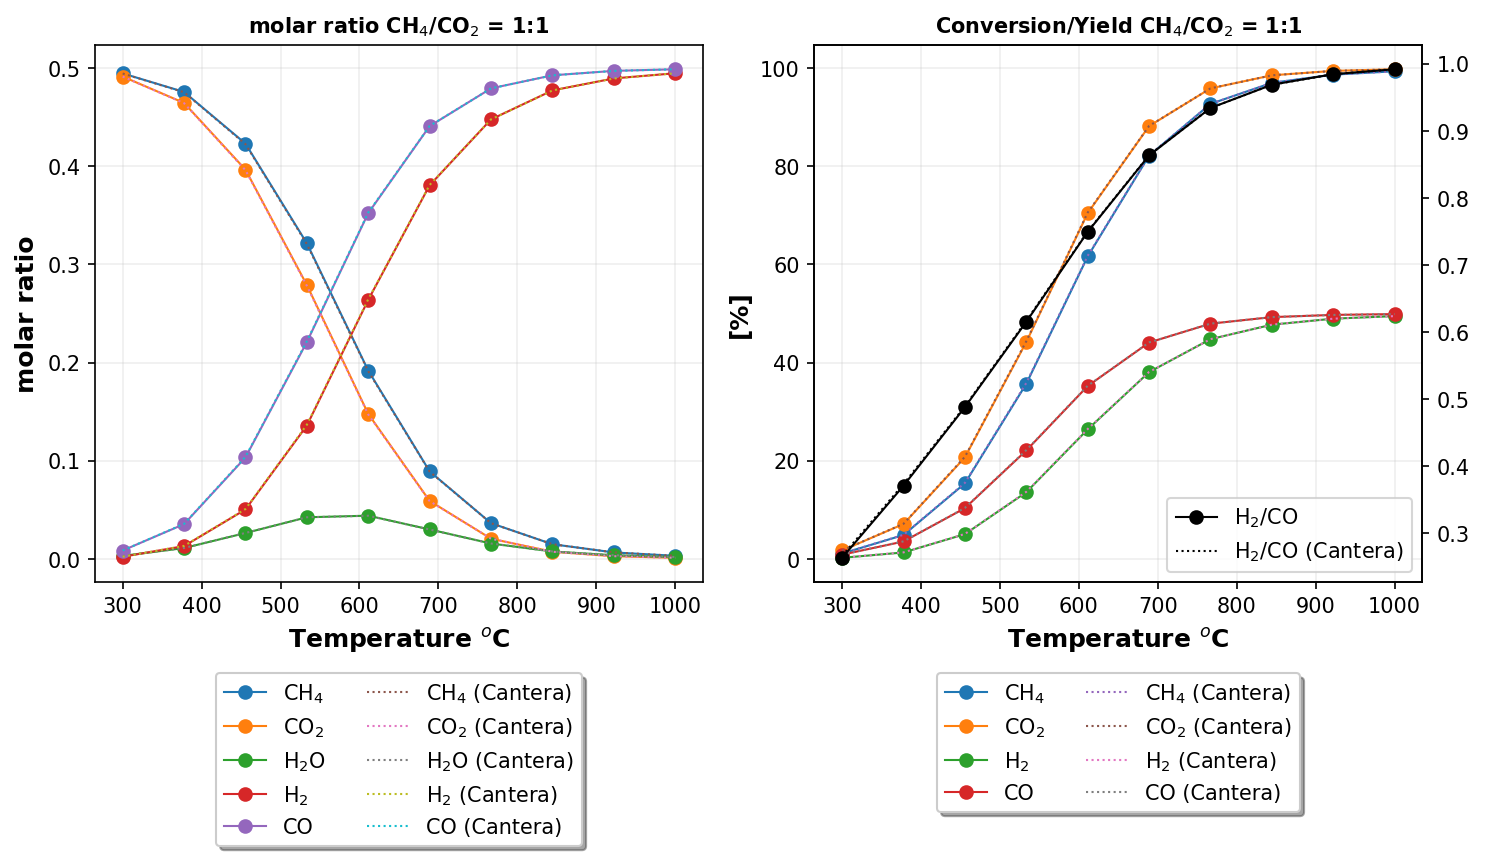

In [9]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,6), dpi = 150)

for j, arr in enumerate(yj.T):
    ax[0].plot(Temp_range - 273.15, arr, "-o", label = species[j], lw = 1)
       
ax[0].set_title('molar ratio CH$_4$/CO$_2$ = 1:1', fontsize=10, fontweight='bold')
ax[0].set_ylabel('molar ratio', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')
ax[0].grid(ls="-", alpha = 0.2)

# Cantera plots
ax[0].plot(Temp_range-273.15, ch4_eq_combined, ':', label = 'CH$_4$ (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, co2_eq_combined, ':', label = 'CO$_2$ (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, h2o_eq_combined, ':', label = 'H$_2$O (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, h2_eq_combined, ':', label = 'H$_2$ (Cantera)', lw = 1)
ax[0].plot(Temp_range-273.15, co_eq_combined, ':', label = 'CO (Cantera)', lw = 1)


ax[1].plot(Temp_range - 273.15, Xch4_equilbrium, "-o", label = 'CH$_4$', lw = 1)
ax[1].plot(Temp_range - 273.15, Xco2_equilbrium, "-o", label = 'CO$_2$', lw = 1)
ax[1].plot(Temp_range - 273.15, Yh2_equilbrium, "-o", label = 'H$_2$', lw = 1)
ax[1].plot(Temp_range - 273.15, Yco_equilbrium, "-o", label = 'CO', lw = 1)
ax[1].set_title('Conversion/Yield CH$_4$/CO$_2$ = 1:1', fontsize=10, fontweight='bold')
ax[1].set_ylabel('[%]', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')

ax[1].plot(Temp_range-273.15, Xch4_eq_combined, ':', label = 'CH$_4$ (Cantera)', lw = 1)
ax[1].plot(Temp_range-273.15, Xco2_eq_combined, ':', label = 'CO$_2$ (Cantera)', lw = 1)
ax[1].plot(Temp_range-273.15, Xh2_eq_combined, ':', label = 'H$_2$ (Cantera)', lw = 1)
ax[1].plot(Temp_range-273.15, Xco_eq_combined, ':', label = 'CO (Cantera)', lw = 1)
ax[1].grid(ls="-", alpha = 0.2)

ax_b = ax[1].twinx()
ax_b.plot(Temp_range-273.15, h2_co, "ko-", label = 'H$_2$/CO', lw = 1)
ax_b.plot(Temp_range-273.15, h2_co_ratio_combined, 'k:', label = 'H$_2$/CO (Cantera)', lw = 1)

# Legends
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)
ax_b.legend(loc = "lower right")

fig.tight_layout()

### Observations

Excellent convergence between two methods. 

Next equilibrium composition when solid carbon is present is going to be investigated using Gibbs minimization.

### ii) Equilibrium composition - with solid carbon C(s)

When solid carbon (graphite) is present, the solid-vapor equilibrium for free energy of carbon is used as:

$\bar{G}_{C(g)}=\bar{G}_{C(S)}={G}_{C(S)}\cong\Delta G^o_{fC(s)}$

Substituting Eqs. for gaseous species and for solid species, the function for free energy minimization is as:

${\sum_{j=1}^n n_j}(\Delta G^o_{fj}+RTln\frac{n_j}{\sum n_j}\frac{P}{P_o})+(n_c\Delta G^o_{fC(s)})=0$

in which, 

$\bar{G}_{C(g)}$ is the partial molar Gibbs free energy of gaseous carbon\
$\bar{G}_{C(S)}$ is the partial molar Gibbs free energy of solid carbon\
${G}_{C(S)}$ is the molar Gibbs free energy of solid carbon\
$\Delta G^o_{fC(s)}$ is the standard Gibbs function of formation of solid carbon\
$n_c$ is the mole of carbon 


**Total Gibbs free energy is considered to be independent of carbon, since solid carbon’s free energy of formation is zero, and it has no vapor pressure. Therefore, carbon is included only in the elemental constraints but not in the objective function.**

In [10]:
species_Cs = ['CH$_4$', 'CO$_2$', 'H$_2$O', 'H$_2$', 'CO', 'C']

ch4, co2, h2o, h2, co, c = np.arange(6)

dGf_carbon = -5.0 #kJ/mol

# objective function
def func_Cs(n):
    
    n = np.array(n)
    
    nj = n[:-1] # moles of gas
    nc = n[-1]  # moles of carbon
    
    Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / Po)
    
    return np.dot(nj, Gj)+(nc*dGf_carbon)

In [11]:
                # CH4,  CO2,  H2O,   H2,   CO,   C(s) 
a_jk = np.array([[ 1,    1,    0,    0,    1,    1],   # C balance
                 [ 0,    2,    1,    0,    1,    0],   # O balance
                 [ 4,    0,    2,    2,    0,    0]])  # H balance


                       # CH4,  CO2 
a_jk_inlet = np.array([[ 1,    1],   # C balance
                       [ 0,    2],   # O balance
                       [ 4,    0]])  # H balance


# ratio of inlet species in the gas mixture
inlet_species = np.array([0.5, 0.5])

# incoming feed
A_k = np.dot(a_jk_inlet, inlet_species)
              
def ec1_Cs(n):
    n = np.array(n)
    '''conservation of atoms constraint - equality constraint'''
    return np.dot(a_jk, n) - A_k

def ic1_Cs(n):
    n = np.array(n)
    '''inequality constraint all n>=0'''
    return n

In [12]:
R = 8.314e-3 # kJ/mol/K
P = 1.0 # atm, this is the total pressure in the reactor
Po = 1.0 # atm, this is the standard state pressure

inlet_ratio_Cs = np.array([0.5, 0.5, 0.0, 0.0, 0.0, 0.0])
bnds = [(0, 10), (0, 10), (0, 10), (0, 10), (0, 10), (0, 10)]

yj_Cs = [] # molar ratio composition 
Temp_range = np.linspace(373+273.15, 1000+273.15, 23)

for T in Temp_range:
    
    n0_Cs = [1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4]  # initial guesses
    sol_Cs = fmin_slsqp(func_Cs, n0_Cs, f_eqcons=ec1_Cs, f_ieqcons=ic1_Cs, bounds=bnds, iter=1000)
    yj_Cs.append(sol_Cs/np.sum(sol_Cs))

C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_14980\2762387439.py:15: RuntimeWarning: divide by zero encountered in log
  Gj = Gibbs_formation_gas(T) + R*T*np.log(nj / np.sum(nj) * P / Po)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -377.8962782071038
            Iterations: 17
            Function evaluations: 127
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: -384.77021757983306
            Iterations: 27
            Function evaluations: 205
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: -391.7926088155159
            Iterations: 19
            Function evaluations: 136
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -398.9818718400965
            Iterations: 21
            Function evaluations: 152
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: -406.36306844433847
            Iterations: 27
            Functi

In [13]:
yj_Cs = np.array(yj_Cs)

yj_Cs.T

array([[1.28635986e-01, 1.32271087e-01, 1.33191304e-01, 1.31425390e-01,
        1.26937860e-01, 1.20206748e-01, 1.11554034e-01, 1.01443380e-01,
        9.04495730e-02, 7.90818484e-02, 6.79428584e-02, 5.75424684e-02,
        4.82851379e-02, 4.02512650e-02, 3.35519491e-02, 2.46695007e-02,
        1.78860955e-02, 1.31019535e-02, 9.68368736e-03, 7.24717850e-03,
        5.49459377e-03, 4.20549575e-03, 3.26241969e-03],
       [1.53471971e-01, 1.65787437e-01, 1.76539389e-01, 1.85176302e-01,
        1.90742305e-01, 1.92278465e-01, 1.88578450e-01, 1.78462749e-01,
        1.60997595e-01, 1.36634533e-01, 1.07475080e-01, 7.76954168e-02,
        5.18340189e-02, 3.24952393e-02, 1.96196586e-02, 1.31086476e-02,
        9.01716759e-03, 6.26672589e-03, 4.40838222e-03, 3.14513159e-03,
        2.27406605e-03, 1.66497243e-03, 1.23744074e-03],
       [3.20188659e-01, 2.97441309e-01, 2.73520262e-01, 2.48493236e-01,
        2.22646411e-01, 1.96354907e-01, 1.69827223e-01, 1.43324742e-01,
        1.17496523e-01

In [14]:
# conversions
Xch4_equilbrium_Cs = ((inlet_ratio_Cs[ch4] - yj_Cs.T[ch4])/inlet_ratio_Cs[ch4])*100
Xco2_equilbrium_Cs = ((inlet_ratio_Cs[co2] - yj_Cs.T[co2])/inlet_ratio_Cs[co2])*100

# yields
Yh2_equilbrium_Cs = ((yj_Cs.T[h2])/(2*inlet_ratio_Cs[ch4]))*100
Yco_equilbrium_Cs = ((yj_Cs.T[co])/(inlet_ratio_Cs[ch4] + inlet_ratio_Cs[co2]))*100

# ratio h2/co
h2_co_Cs = yj_Cs.T[h2]/yj_Cs.T[co]

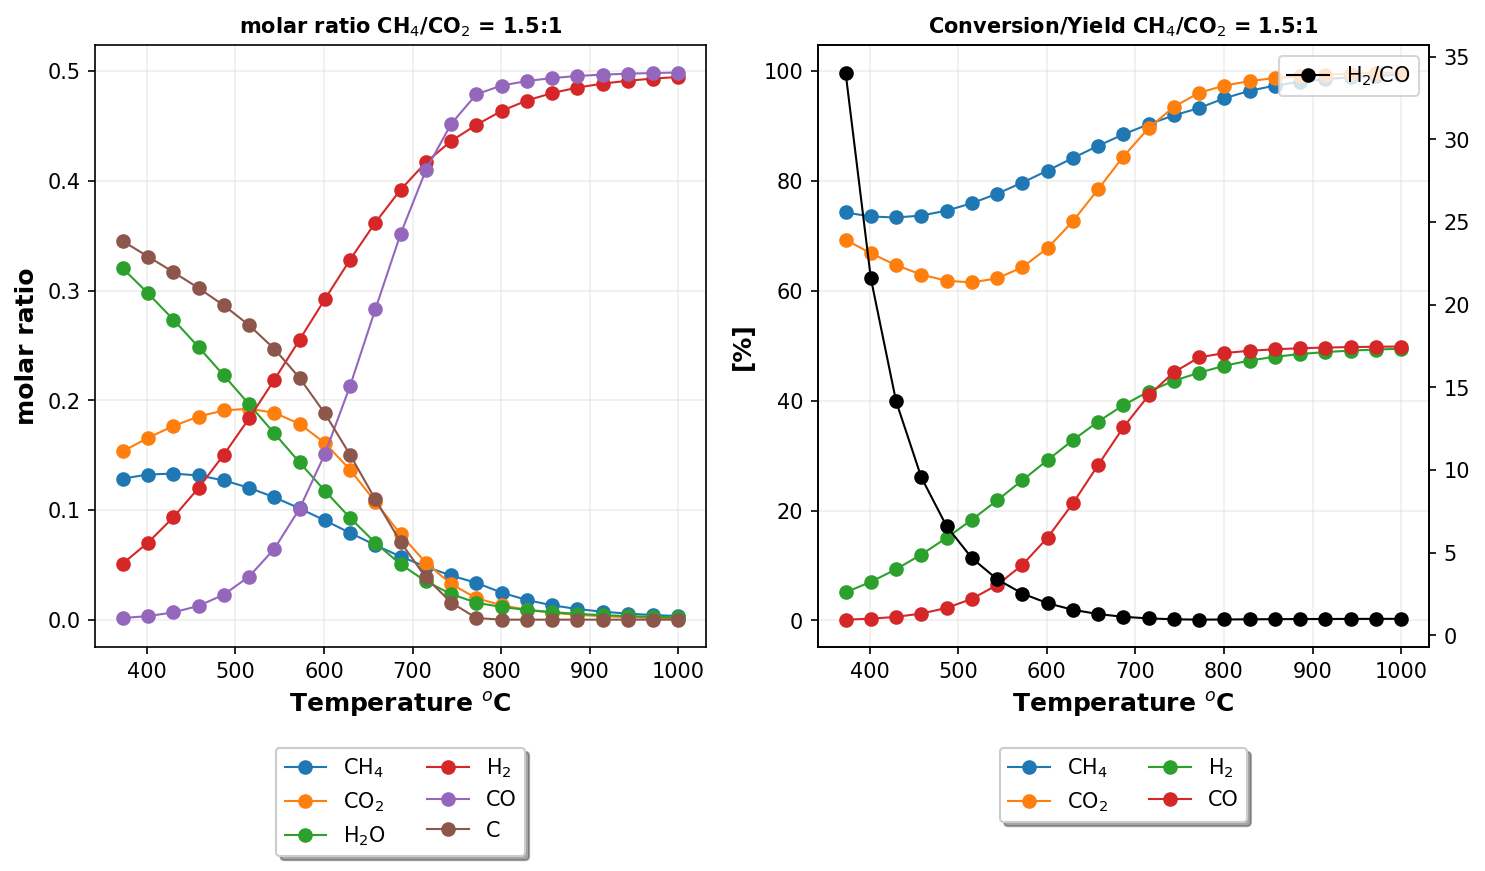

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,6), dpi = 150)

for j, arr in enumerate(yj_Cs.T):
    ax[0].plot(Temp_range - 273.15, arr, "-o", label = species_Cs[j], lw = 1)
    
ax[0].set_title('molar ratio CH$_4$/CO$_2$ = 1.5:1', fontsize=10, fontweight='bold')
ax[0].set_ylabel('molar ratio', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')
ax[0].grid(ls="-", alpha = 0.2)


ax[1].plot(Temp_range - 273.15, Xch4_equilbrium_Cs, "-o", label = 'CH$_4$', lw = 1)
ax[1].plot(Temp_range - 273.15, Xco2_equilbrium_Cs, "-o", label = 'CO$_2$', lw = 1)
ax[1].plot(Temp_range - 273.15, Yh2_equilbrium_Cs, "-o", label = 'H$_2$', lw = 1)
ax[1].plot(Temp_range - 273.15, Yco_equilbrium_Cs, "-o", label = 'CO', lw = 1)
ax[1].set_title('Conversion/Yield CH$_4$/CO$_2$ = 1.5:1', fontsize=10, fontweight='bold')
ax[1].set_ylabel('[%]', fontsize=12, fontweight='bold')
ax[1].set_xlabel('Temperature $^o$C', fontsize=12, fontweight='bold')
ax[1].grid(ls="-", alpha = 0.2)

ax_b = ax[1].twinx()
ax_b.plot(Temp_range-273.15, h2_co_Cs, "ko-", label = 'H$_2$/CO', lw = 1)

# Legends
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)
ax_b.legend(loc = "best")

fig.tight_layout()